In [3]:
import os
import uuid

from dotenv import load_dotenv
import numpy as np
from PIL import Image

from labelbox import Client, Project, Dataset, LabelingFrontend
from labelbox.data.serialization import COCOConverter, NDJsonConverter
from labelbox.data.annotation_types import (
    Mask, 
    MaskData, 
    ObjectAnnotation, 
    LabelList, 
    Point, 
    Rectangle, 
    Polygon, 
    ImageData, 
    Label,
    ScalarMetric
)
from labelbox.data.metrics.group import get_label_pairs
from labelbox.schema.media_type import MediaType
from labelbox.schema.ontology import OntologyBuilder

from labelbox.data.metrics import (
    feature_miou_metric, 
    feature_confusion_matrix_metric
)
from labelbox.schema.model import Model

import torch

import matplotlib.pyplot as plt

from koger_detection.obj_det.predictors import Predictor

In [6]:
# class Predictor:
#     """ Assumes images are passed as H x W x 3 with values from 0 to 255."""
    
#     def __init__(self, cfg, model_weights_path=None, rgb=True):
#         """
#         Args:
#             cfg: config dictionary
#             model_weights_path: full path to model weights to use
#             rgb: if images will be passed as RGB
#         """
#         self.rgb = rgb
        
#         if model_weights_path is None:
#             model_weights_pth = cfg.pop("model_weights_pth")
#         elif "model_weights_pth" in cfg:
#             cfg.pop("model_weights_pth")
            
#         self.model = get_detection_model(**cfg)
#         self.model.load_state_dict(torch.load(model_weights_pth))
        
#         # train on the GPU or on the CPU, if a GPU is not available
#         if torch.cuda.is_available():
#             device = torch.device('cuda')  
#         else:
#             device = torch.device('cpu')
        
#         self.model.to(device)
#         self.model.eval()
        
#     def __call__(self, image):
#         if self.rgb:
#             # image is loaded as RGB but needs to be in BGR
#             image = image[:, :, ::-1]
#         image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
#         if torch.cuda.is_available():
#             image = image.cuda()
#         image /= 255.0
#         with torch.no_grad():
#             return self.model([image])[0]
            

def get_label(image, predictor, class_names, score_thrs=.5):
    """Create labelbox annotations for an image.
    
    Args:
        image: labelbox ImageData object for image
        predictor: Predictor class
        class_names: list of class names in the ontology of labelbox project
            these will be loaded to in the same order as in the ontology
    
    """

  # This is a bit slow, there is some i/o for downloading the 
  # images but then inference is slow
  # Runs inference on an image and returns a label
    res = predictor(image.value)
    
    annotations = []
    for idx in range(len(res['boxes'])):
        if res['scores'][idx].to('cpu').numpy() < score_thrs:
            continue
        box = (res['boxes'][idx].to('cpu').numpy().astype(np.uint32))
        class_num = res['labels'][idx].cpu().numpy().astype(np.uint32)
        class_name = class_names[class_num-1]

        annotations.append(
            ObjectAnnotation(name = class_name,
                             value = Rectangle(start=Point(x=box[0], y=box[1]), 
                                               end=Point(x=box[2], y=box[3])
                                              )
                            )
        )
    return Label(data = image, annotations = annotations)

In [4]:
load_dotenv()
client = Client(api_key=os.environ.get('LABELBOX_API_KEY'))

In [5]:
import json

# This file records which raw video files should be used for 
# training, validation, and testing
# Format of .json is:
# {"train": ["file1.mp4", "file2.mp4"], 
#  "val": ["file3.mp4", "file4.mp4"],
#  "test": ["file5.mp4", "file6.mp4"]
# }

# can instead just manually create a list of video names
# and pass that to the variable 'video_names' below
json_file = "/home/koger/Dropbox/UWWRF/detection/high-altitude/high-altitude-overhead/detection/model-training/video_train_val_test_split.json"
with open(json_file) as f:
    video_splits = json.load(f)

In [ ]:
# Path to folder where videos are saved
video_folder_path = "/media/koger/HDD2022_3/bristolbay"
# Add model config path and load it into a dictionary
model_config_path = "

data_type = "train-all"
video_names = video_splits[data_type]

crop_size = 1024 # Either none for whole image or size in pixels (square crops)

In [ ]:
frame_nums = []
confidence_scores = []

frames_per_video = 100
crop_size = 1024
score_thrs = .5

for video_name in video_names:
        video_file = os.path.join(video_folder_path, video_name)
        video_name = os.path.splitext(video_name)[0] # remove extension

        cap = cv2.VideoCapture(video_file)
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        if max_frame is None:
            max_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) + 1
            
        # Randomly choose the specified number of frames to extract from the given range
        frame_nums_to_save = np.random.randint(min_frame, max_frame, frames_per_video)
        for frame_num in frame_nums_to_save:
            top_left = random_top_left([height, width], crop_size, gaussian=False)
            if top_left is False:
                print(f"skipping {frame_file}")
                print(f"No valid crop found. Check frame size and crop size.")
                print(f"Frame size h:{height}, w:{width}, crop_size: {crop_size}.")
                continue
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if frame is not None:
                if crop_size:
                    if not top_left:
                        raise ValueError(f"If cropping, must provide top_left: {top_left}")
                    top, left = top_left
                    frame = frame[top:top+crop_size, left:left+crop_size]
                res = predictor(frame)
    
                annotations = []
                for idx in range(len(res['boxes'])):
                    if res['scores'][idx].to('cpu').numpy() < score_thrs:
                        continue
                    box = (res['boxes'][idx].to('cpu').numpy().astype(np.uint32))
                    class_num = res['labels'][idx].cpu().numpy().astype(np.uint32)
                    class_name = class_names[class_num-1]

            

In [ ]:
# Path to main folder within which images will be saved
annotations_folder = "/home/koger/Dropbox/UWWRF/detection/high-altitude/annotations/extracted_frames/crops"
os.makedirs(annotations_folder, exist_ok=True)
# Path to folder where videos are saved
video_folder_path = "/media/koger/HDD2022_3/bristolbay"

# Which type of videos to extract from based on naming in our saved .json file
# this could be "train", "validate", or "test"
project_name = "salmon-high-alt"
data_type = "train-all"
annotation_round = 1

dataset_name = f"{project_name}-{data_type}_{annotation_round}"

# list of video names to use
video_names = video_splits[data_type]

save_folder = os.path.join(annotations_folder, dataset_name)
# setting min and max frames can be used if part of video will go in the training set
# and part of the video will go in the validation set
min_frame = 0 # begining of range frames could be extracted from
max_frame = None # end of range (exclusive) frames could be extracted from (
                 # set to "None" if range should extend through last frame)
num_extract = 7 # number of frames to extract and save
save_triplet = True # If True, for each frame should save a frame a little before 
                    # and a little after focal frame (Can be helpful when 
                    # movement helps find cryptic individuals)
triplet_spacing = 20 # How many frames in future and past to space outer 
                     # triplet frames around focal frame (ignored if 
                    # save_triplet is False)
crop_size = 1024 # Either none for whole image or size in pixels (square crops)

In [8]:
# Some additional unlabeled data rows
dataset = next(client.get_datasets(where=(Dataset.name=="salmon-high-alt-train-all_1")))
print(dataset)

<Dataset {
    "created_at": "2024-02-08 00:02:22.985000+00:00",
    "description": "",
    "name": "salmon-high-alt-train-all_1",
    "row_count": 162,
    "uid": "clscgfibt000007410ge9hie7",
    "updated_at": "2024-02-08 00:02:22.985000+00:00"
}>


In [15]:
model_cfg = {'num_classes': 3,
       'model_weights_pth': "/home/koger/Dropbox/UWWRF/detection/high-elevation/runs/main/03-09-2024-13-48-48/final_model.pth",
       'box_detections_per_img': 300,
       'fixed_size': [1024, 1024],
       'model_type': "bbox_v2"
       }

In [16]:
predictor = Predictor(model_cfg)

In [13]:

# images = []
# for data_row in data_rows:
#     images.append(ImageData(url = data_row.row_data, 
#                             uid = data_row.uid, 
#                             external_id = data_row.external_id))


In [17]:
ontology = next(client.get_ontologies("salmon"))
class_names = [o['name'] for o in ontology.normalized['tools']] 

data_rows = dataset.data_rows()
labels_mal = LabelList()
for data_row in data_rows:
    image = ImageData(url = data_row.row_data, 
                      uid = data_row.uid, 
                      external_id = data_row.external_id)
    labels_mal.append(
        get_label(image, predictor, class_names, score_thrs=.7)
    )
# Allows us to upload local images to labelbox
signer = lambda _bytes: client.upload_data(content=_bytes, sign=True)
labels_mal.add_url_to_masks(signer).add_url_to_data(signer) 

162it [00:00, 751634.12it/s]
162it [00:00, 780111.65it/s]


In [18]:
labels_mal.get_ontology().asdict()

{'tools': [{'tool': 'rectangle',
   'name': 'salmon',
   'required': False,
   'color': '#ff0000',
   'classifications': [],
   'schemaNodeId': None,
   'featureSchemaId': None},
  {'tool': 'rectangle',
   'name': 'bear',
   'required': False,
   'color': '#00ffff',
   'classifications': [],
   'schemaNodeId': None,
   'featureSchemaId': None}],
 'classifications': []}

In [19]:
ontology = next(client.get_ontologies("salmon-high-altitude-train-2"))
ont_dict = OntologyBuilder.from_ontology(ontology).asdict()
for t_dict in ont_dict['tools']:
    t_dict['schemaNodeId'] = None
    t_dict['featureSchemaId'] = None
ont_dict

{'tools': [{'tool': 'rectangle',
   'name': 'salmon',
   'required': False,
   'color': '#ff0000',
   'classifications': [],
   'schemaNodeId': None,
   'featureSchemaId': None},
  {'tool': 'rectangle',
   'name': 'bear',
   'required': False,
   'color': '#00ffff',
   'classifications': [],
   'schemaNodeId': None,
   'featureSchemaId': None}],
 'classifications': []}

In [20]:
# Create a new project for upload
project = client.create_project(name="salmon-high-altitude-train-5", media_type=MediaType.Image)
editor = next(
    client.get_labeling_frontends(where=(LabelingFrontend.uid == "ck87gvhzmee7208260krehqu7"))
) # uid for standard editor. Finding by name isn't working for some reason.
# ontology = next(client.get_ontologies("salmon"))
project.setup(editor, ont_dict)
project.enable_model_assisted_labeling()
batch = project.create_batch(
  "Initial batch",
   list(dataset.export_data_rows()), # sample of data row objects
  5 # priority between 1(Highest) - 5(lowest)
)
# project.datasets.connect(dataset)

Default createProject behavior will soon be adjusted to prefer batch projects. Pass in `queue_mode` parameter explicitly to opt-out for the time being.


In [21]:
project.ontology

In [22]:
ndjsons = list(NDJsonConverter.serialize(labels_mal))
upload_task = project.upload_annotations(name=f"upload-job-{uuid.uuid4()}",
                                     annotations=ndjsons,
                                     validate=False)
# Wait for upload to finish
upload_task.wait_until_done()
# Review the upload status
print(upload_task.errors)

[]


In [18]:
train_im_file = "/home/koger/Dropbox/UWWRF/detection/high-altitude/annotations/extracted_frames/crops/train2_1/bear_big_2022_08_13_berdahl_02_3_DJI_0988_frame_2415_top_218_left_417_b.jpg"
im_train = plt.imread(train_im_file)
im_train.shape

(1024, 1024, 3)

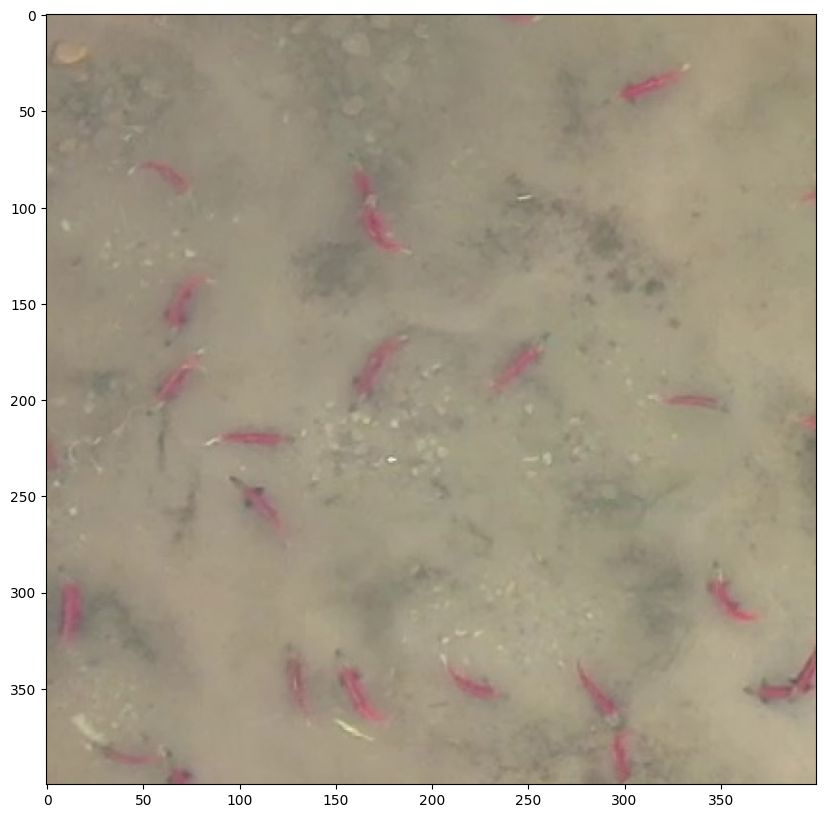

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(im_train[-400:, -400:])

1750
(3648, 5472, 3)


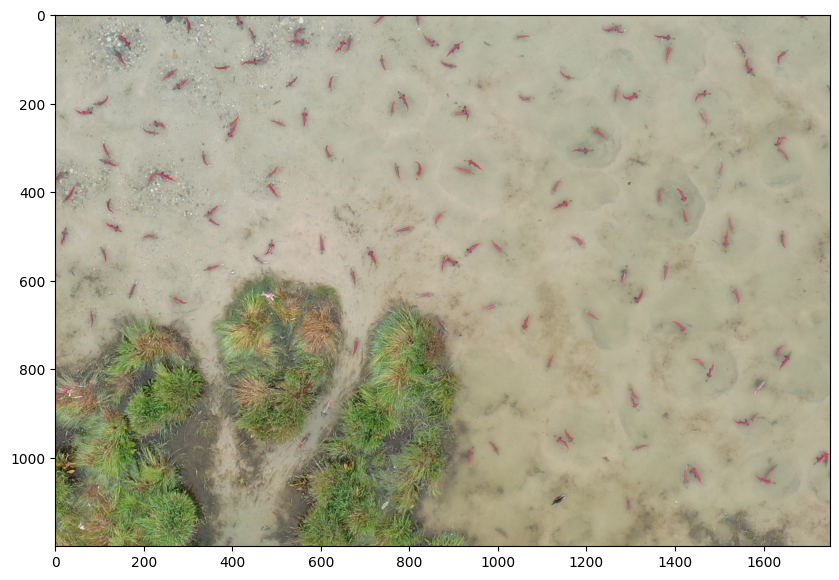

In [12]:
im_folder = "/media/koger/HDD2022_3/bristolbay/aug12"
im_file = "DJI_0874.JPG"

im = plt.imread(os.path.join(im_folder, im_file))
x_low = 2000
x_high = 3750
y_low = 1500
y_high = 2700

print(np.max([x_high-x_low, y_high-y_low]))
im_crop = im[y_low:y_high, x_low:x_high]
plt.figure(figsize=(10, 10))
plt.imshow(im_crop)
print(im.shape)

In [15]:
# im = images[20].value

im_pred = im_crop
res = predictor(im_pred)

boxes = res['boxes'].to('cpu').numpy().astype(np.uint32)
scores = res['scores'].to('cpu').numpy()

126


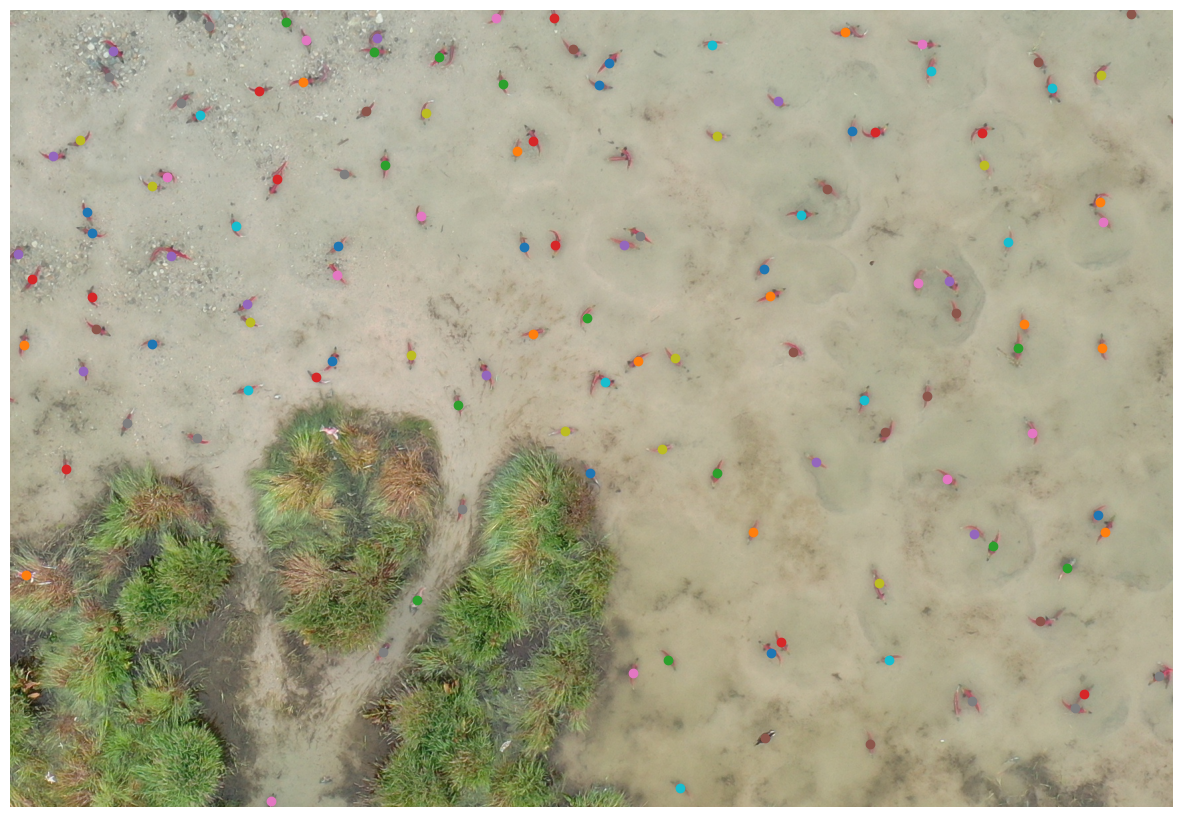

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(im_pred)

num_drawn = 0

for box, score in zip(boxes, scores):
    if score < .5:
        continue
    x = np.mean([box[0], box[2]])
    y = np.mean([box[1], box[3]])
    plt.scatter(x, y, alpha=1.0)
    num_drawn += 1
plt.axis('off')
print(num_drawn)
fname = os.path.join("/home/koger/Dropbox/UWWRF/detection/high-altitude/media",
                     "DJI_0874_full.jpg")
plt.savefig(fname, dpi=300, bbox_inches='tight')

In [54]:
len(res['labels'])

75

In [ ]:



# Use ThreadPoolExecutor to parallelize image downloads.
# This is still a bit slow due to the amount of processing for each data row.
# For larger datasets this has to leverage multiprocessing.

labels_mal = LabelList()
with ThreadPoolExecutor(4) as executor:
    data_rows = dataset.data_rows()
    images = [ImageData(url = data_row.row_data, uid = data_row.uid, external_id = data_row.external_id) for data_row in data_rows]
    futures = [executor.submit(get_label, image) for image in images]
    for future in tqdm(as_completed(futures)):
        labels_mal.append(future.result())

In [101]:
ontology.normalized['tools']

[{'schemaNodeId': 'cldup7n5y6qop07yzbhtd7qov',
  'featureSchemaId': 'cldup7n5y6qoq07yzd1c589r8',
  'required': False,
  'name': 'salmon',
  'tool': 'rectangle',
  'color': '#ff0000',
  'archived': 0,
  'classifications': []},
 {'schemaNodeId': 'cldup7n5z6qor07yzdz8i9w3k',
  'featureSchemaId': 'cldup7n5z6qos07yz4vqt01lm',
  'required': False,
  'name': 'bear',
  'tool': 'rectangle',
  'color': '#00ffff',
  'archived': 0,
  'classifications': []}]

In [ ]:
# Load model instance and dataloader for inference

In [ ]:
# Create a new project for upload
project = client.create_project(name="salmon-high-altitude-train-3", media_type=MediaType.Image)
editor = next(
    client.get_labeling_frontends(where=(LabelingFrontend.uid == "ck87gvhzmee7208260krehqu7"))
) # uid for standard editor. Finding by name isn't working for some reason.
ontology = next(client.get_ontologies("salmon"))
project.setup(editor, ontology)
project.enable_model_assisted_labeling()
batch = project.create_batch(
  "Initial batch",
   list(dataset.export_data_rows()), # sample of data row objects
  5 # priority between 1(Highest) - 5(lowest)
)
# project.datasets.connect(dataset)